In [0]:
#============================== Classification Test ====================================================
# the idea here is to test different types of texts - Qur'aan, Hadith, Poetry, modern text (news, novels, social media, ...)
# this notebook explores only the first 3 categories

In [1]:
!pip uninstall fastai --y
!pip install ninja
!pip install sentencepiece
!pip install fastai==1.0.57  # restart runtime then if done after fastai is imported

Uninstalling fastai-1.0.60:
  Successfully uninstalled fastai-1.0.60
     |████████████████████████████████| 102kB 5.5MB/s 
     |████████████████████████████████| 1.0MB 9.2MB/s 
     |████████████████████████████████| 235kB 9.3MB/s 


In [0]:
# fastai version 1.0.57
from fastai import *
from fastai.text import *
from fastai.callbacks import *

import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import fastai
print(f'fastai: {fastai.__version__}')  # source above used 1.0.57
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.57
cuda: True


In [0]:
!cp '/content/drive/My Drive/Colab Notebooks/ds2020/armultifit/qhp_texts.csv' /content/

In [0]:
df = pd.read_csv('/content/qhp_texts.csv', sep=',', encoding='utf-8')


In [7]:
len(df)

39057

In [8]:
df.dropna(inplace=True)
len(df)

39057

In [0]:
#df.sample(20)

In [0]:
import matplotlib.cm as cm
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='weighted')

import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "on

In [0]:
# source: https://github.com/fastai/fastai/blob/master//fastai/layers.py#L300:7
# blog: https://bfarzin.github.io/Label-Smoothing/
class WeightedLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight, eps:float=0.1, reduction='mean'):
        super().__init__()
        self.weight,self.eps,self.reduction = weight,eps,reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, weight=self.weight, reduction=self.reduction)

In [0]:
# to solve display error of pandas dataframe (not sure if needed here)
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [0]:
!mkdir -p /content/models/ 
# need to move vocab and model here for fastai to work
!mkdir -p /root/.fastai/data/arwiki/corpus2_100/tmp/ 
# assuming files in drive
!cp '/content/drive/My Drive/Colab Notebooks/ds2020/armultifit/ar_sp12/spm.vocab' /root/.fastai/data/arwiki/corpus2_100/tmp/spm.vocab
!cp '/content/drive/My Drive/Colab Notebooks/ds2020/armultifit/ar_sp12/spm.model' /root/.fastai/data/arwiki/corpus2_100/tmp/spm.model

In [15]:
dest = '/root/.fastai/data/arwiki/corpus2_100/'
path = '/content/'
!ls -la /root/.fastai/data/arwiki/corpus2_100/

total 12
drwxr-xr-x 3 root root 4096 Jan 27 15:58 .
drwxr-xr-x 3 root root 4096 Jan 27 15:58 ..
drwxr-xr-x 2 root root 4096 Jan 27 15:59 tmp


In [0]:
# columns names
reviews = "text"
label = "class"
bs=50

In [17]:
%%time
data_lm = (TextList.from_df(df, path, cols=reviews, processor=SPProcessor.load(dest))
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

CPU times: user 1.99 s, sys: 91.3 ms, total: 2.08 s
Wall time: 3.96 s


In [0]:
data_lm.save(f'/content/models/ar_databunch_lm_qhp_sp12_multifit')

In [0]:
# try without models, as trainer creates a /models/ folder
path_ds = '/content/models/'
data_lm = load_data(path_ds, 'ar_databunch_lm_qhp_sp12_multifit', bs=bs)

In [0]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [0]:
# bring trained wiki files (weights and vocab)
!cp '/content/drive/My Drive/Colab Notebooks/ds2020/armultifit/ar_sp12/ar_wt_sp12_multifit.pth' /content/models/ 
!cp '/content/drive/My Drive/Colab Notebooks/ds2020/armultifit/ar_sp12/ar_wt_vocab_sp12_multifit.pkl' /content/models/

In [0]:
lm_ar = ['/content/models/ar_wt_sp12_multifit', '/content/models/ar_wt_vocab_sp12_multifit']

In [23]:
%%time
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, 
                                  pretrained_fnames=lm_ar, drop_mult=1., # also 0.3 used for FR
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 3.12 s, sys: 1.07 s, total: 4.19 s
Wall time: 56.4 s


In [24]:
# number of model parameters
sum([p.numel() for p in learn_lm.model.parameters()])

44817150

In [0]:
#learn_lm.model

In [25]:
learn_lm.loss_func

FlattenedLoss of CrossEntropyLoss()

In [26]:
# may not be needed for binary balanced classification (here multilabel unbalanced)
learn_lm.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)
learn_lm.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 4.64E-02


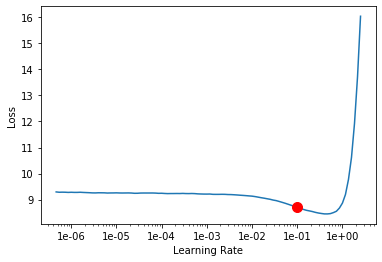

In [27]:
learn_lm.lr_find(num_it=120, stop_div=True)
learn_lm.recorder.plot(suggestion=True)

In [0]:
lr = 2e-2 
lr *= bs/50
wd = 0.1 

In [29]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,16.737259,7.468085,0.919490,0.080510,983.141663,00:29
1,6.210994,5.989960,0.807265,0.192735,218.191177,00:28


In [0]:
# saving optional
learn_lm.save(f'ar_fine_tuned1_qhp_sp12_multifit')
learn_lm.save_encoder(f'ar_fine_tuned1_enc_qhp_sp12_multifit')

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,5.354362,5.179316,0.711299,0.288701,89.431717,00:38
1,5.057788,4.920049,0.678054,0.321946,67.120506,00:38
2,5.059725,4.909671,0.679034,0.320966,63.882679,00:38
3,4.997087,4.866829,0.678687,0.321313,61.364693,00:38
4,4.906450,4.768221,0.662612,0.337388,55.010338,00:38
5,4.789160,4.668379,0.649748,0.350252,49.486717,00:38
6,4.647646,4.551444,0.637653,0.362347,43.269382,00:38
7,4.499552,4.451342,0.620354,0.379646,38.758228,00:38
8,4.380407,4.385240,0.610565,0.389435,35.975986,00:38
9,4.301546,4.374159,0.608265,0.391735,35.345943,00:38


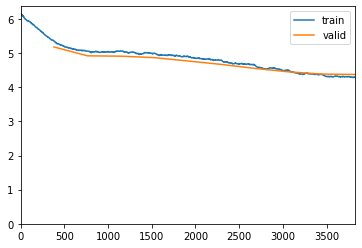

In [31]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [0]:
# best model and encoder 
learn_lm.save(f'ar_fine_tuned_qhp_sp12_multifit')
learn_lm.save_encoder(f'ar_fine_tuned_enc_qhp_sp12_multifit')

In [0]:
# fine-tune classifier (fwd)
bs = 18

In [34]:
%%time
data_lm = load_data(path_ds, 'ar_databunch_lm_qhp_sp12_multifit', bs=bs)

CPU times: user 208 ms, sys: 15.8 ms, total: 223 ms
Wall time: 230 ms


In [35]:
%%time
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols=reviews, processor=SPProcessor.load(dest))
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols=label)
    .databunch(bs=bs, num_workers=1))

CPU times: user 3.04 s, sys: 197 ms, total: 3.23 s
Wall time: 4.96 s


In [36]:
%%time
data_clas.save(f'/content/models/ar_textlist_class_qhp_sp12_multifit')

CPU times: user 609 ms, sys: 59.4 ms, total: 669 ms
Wall time: 670 ms


In [0]:
# Get weights to penalize loss function of the majority class

In [37]:
%%time
data_clas = load_data(path_ds, f'ar_textlist_class_qhp_sp12_multifit', bs=bs, num_workers=1)

CPU times: user 1.31 s, sys: 15 ms, total: 1.33 s
Wall time: 1.34 s


In [38]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(35152, 3905, 39057)

In [39]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([ 5603, 19540, 10009]), array([ 633, 2158, 1114]))

In [40]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.8406065088757396, 0.4441283568502503, 0.71526513427401],
 [0.8379001280409731, 0.44737516005121636, 0.7147247119078105])

In [0]:
#Training (Loss = FlattenedLoss of weighted LabelSmoothingCrossEntropy)

In [41]:
%%time
data_clas = load_data(path_ds, f'ar_textlist_class_qhp_sp12_multifit', bs=bs, num_workers=1)

CPU times: user 1.13 s, sys: 7.19 ms, total: 1.14 s
Wall time: 1.14 s


In [0]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [0]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, 
                                  drop_mult=0.3,  # 0.3, was 0.5 for FR
                                  metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'ar_fine_tuned_enc_qhp_sp12_multifit');

In [44]:
# Change loss function
print(learn_c.loss_func)
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)
print(learn_c.loss_func)

FlattenedLoss of CrossEntropyLoss()
FlattenedLoss of WeightedLabelSmoothingCrossEntropy()


epoch,train_loss,valid_loss,accuracy,f1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 3.98E-02


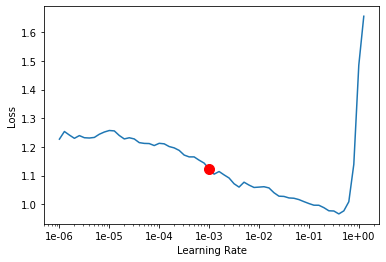

In [45]:
# train 
learn_c.freeze()
learn_c.lr_find(num_it=80, stop_div=True)
learn_c.recorder.plot(suggestion=True)

In [0]:
lr = 5e-4 # was 2e-1 for pt
lr *= bs/48
wd = 0.1 # was 0.01 for FR

In [47]:
# was 2 cycles in 2 cells, try 4 in one cell [may be this is enough for QHP dataset]
learn_c.fit_one_cycle(4, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.603810,0.366842,0.975672,0.979921,00:28
1,0.513248,0.358706,0.984123,0.984770,00:31
2,0.456807,0.354967,0.982843,0.984436,00:30
3,0.493138,0.351594,0.985147,0.986098,00:31


In [48]:
# try 3 or 4 cycles here, 2 were ok (ignore -3)
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.487310,0.348600,0.984379,0.985513,00:36
1,0.464370,0.344442,0.987964,0.988061,00:36


In [49]:
# unfreeze and tune (was 4 cycles, one seems good)
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7)) # 1 cycle in FR

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.458966,0.344312,0.986172,0.986492,01:10
1,0.446561,0.359955,0.987452,0.987985,01:10


In [0]:
learn_c.save(f'ar_clas_qhp_sp12_multifit')
learn_c.to_fp32().export(f'ar_classifier_qhp_sp12_multifit') 

In [0]:
#========================================================
# confusion matrix

In [51]:
%%time
data_clas = load_data(path_ds, f'ar_textlist_class_qhp_sp12_multifit', bs=bs, num_workers=1);

config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

CPU times: user 1.18 s, sys: 48.8 ms, total: 1.23 s
Wall time: 1.2 s


In [0]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False)

In [0]:
learn_c.load(f'ar_clas_qhp_sp12_multifit', purge=False);

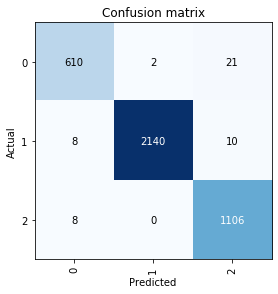

In [54]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [55]:
from sklearn.metrics import confusion_matrix, f1_score
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
#print(f'accuracy global: {(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3])/(cm.sum())}')
print(f'accuracy global: {(cm[0,0]+cm[1,1]+cm[2,2])/(cm.sum())}') # 2 classes

# acc neg, acc pos
print(f'accuracy on class 0: {cm[0,0]/(cm.sum(1)[0])*100}') 
print(f'accuracy on class 1: {cm[1,1]/(cm.sum(1)[1])*100}')
print(f'accuracy on class 2: {cm[2,2]/(cm.sum(1)[2])*100}')
#print(f'accuracy on class 3: {cm[3,3]/(cm.sum(1)[3])*100}')



[[ 610    2   21]
 [   8 2140   10]
 [   8    0 1106]]
accuracy global: 0.9874519846350832
accuracy on class 0: 96.36650868878357
accuracy on class 1: 99.16589434661724
accuracy on class 2: 99.2818671454219


In [56]:
print ('F1 score:', f1_score(y, predictions,average='weighted'))

F1 score: 0.9874657147496316


In [57]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.9875), tensor(0.9875))

In [58]:
learn_c.show_results(rows=10, max_len=25)

text,target,prediction
▁xxbos ▁: ▁لم ▁أ زل ▁حر ي صا ▁على ▁أن ▁أ سأل ▁عمر ▁رضي ▁الله ▁عنه ▁عن ▁المر أت ين ▁من ▁أزواج ▁النبي ▁صلى ▁الله,1,1
▁xxbos ▁الله ▁عليه ▁وسلم ▁تلك ▁الغزو ة ▁حين ▁طا بت ▁الث مار ▁وال ظل ال ▁وت جهز ▁رسول ▁الله ▁صلى ▁الله ▁عليه ▁و ▁سلم ▁والم,1,1
▁xxbos ▁قرأ ت ▁ <unk> ▁أرد ت ▁أن ▁ت قرأ ▁. ▁ <unk> ▁قصد ▁السبيل ▁ <unk> ▁البيان ▁وال ه دا ية ▁إلى ▁الطريق ▁المستقيم,1,1
▁xxbos ▁: ▁قل نا ▁يا ▁رسول ▁الله ▁هل ▁نرى ▁رب نا ▁يوم ▁القيام ة ▁؟ ▁قال ▁ <unk> ▁هل ▁ت ضار ون ▁في ▁رؤية ▁الشمس,1,1
▁xxbos ▁: ▁عن ▁النبي ▁صلى ▁الله ▁عليه ▁و ▁سلم ▁ <unk> ▁أن ▁موسى ▁قام ▁خط يب ا ▁في ▁بني ▁إسرائيل ▁ف سئل ▁أي ▁الناس ▁أ,1,1
▁xxbos ▁: ▁م كث ت ▁سنة ▁أر يد ▁أن ▁أ سأل ▁عمر ▁بن ▁الخطاب ▁عن ▁آ ية ▁فما ▁أست طيع ▁أن ▁أ سأل ه ▁هي,1,1
▁xxbos ▁ <unk> ▁ب ذي ▁الحل يفة ▁ <unk> ▁اسم ▁موضع ▁قريب ▁من ▁المدينة ▁ويسمى ▁الآن ▁آ بار ▁علي ▁وهو ▁م يق ات ▁أهل ▁المدينة,1,1
▁xxbos ▁: ▁بعث ني ▁رسول ▁الله ▁صلى ▁الله ▁عليه ▁و ▁سلم ▁والز بير ▁وأب ا ▁م رث د ▁وكل نا ▁فارس ▁قال ▁ <unk> ▁ان,1,1
▁xxbos ▁ <unk> ▁الآ يات ▁ <unk> ▁وهي ▁قول ▁الله ▁تع إ لى ▁ <unk> ▁هذا ن ▁خص مان ▁اخت صم وا ▁في ▁رب هم,1,1
▁xxbos ▁وكان ▁ابن ▁النا طور ▁صاحب ▁إيلي اء ▁و هر قل ▁أسقف ا ▁على ▁ن صار ى ▁الش أم ▁يحدث ▁أن ▁هر قل ▁حين ▁قدم,1,1


In [59]:
# predict random stuff 
test_text =  "عن ابن مسعود قال: قرأت على رسول الله من سورة النساء" # Hadith (category 1)
pred = learn_c.predict(test_text)
print(pred)
test_text = "لا تنه عن خلق وتأتي مثله عار عليك إذا فعلت عظيم" # Poetry (cataegory 2)
pred = learn_c.predict(test_text)
print(pred)
test_text ="أذن للذين يقاتلون بأنهم ظلموا وإن الله على نصرهم لقدير" # Qur'an (category 0)
pred = learn_c.predict(test_text)
print(pred)

(Category 1, tensor(1), tensor([0.0141, 0.9771, 0.0089]))
(Category 2, tensor(2), tensor([0.2129, 0.0691, 0.7180]))
(Category 0, tensor(0), tensor([0.8981, 0.0119, 0.0900]))


In [60]:
# Get the prediction +ve
test_text = "قفا نبك من ذكرى حبيب ومنزل بسقط اللوى بين الدخول فحومل"
pred = learn_c.predict(test_text)
print(pred)

(Category 2, tensor(2), tensor([0.0359, 0.0308, 0.9333]))


In [61]:
# The darker the word-shading in the below example, the more it contributes to the classification. 
txt_ci = TextClassificationInterpretation.from_learner(learn_c)
txt_ci.show_intrinsic_attention(test_text,cmap=plt.cm.Purples)

In [62]:
txt_ci.intrinsic_attention(test_text)[1]

tensor([0.3022, 0.5670, 0.2609, 0.2854, 0.3506, 0.1820, 0.3466, 0.2714, 0.3006,
        0.1942, 0.1856, 0.2220, 0.4827, 0.8558, 0.1818, 0.4319, 0.9958, 0.4419,
        0.3595, 0.6586, 1.0000], device='cuda:0')

In [63]:
import sentencepiece as spm
s = spm.SentencePieceProcessor()
s.Load('/root/.fastai/data/arwiki/corpus2_100/tmp/spm.model')

True

In [64]:
s.decode_pieces("▁xxbos ▁ق فا ▁ن بك ▁من ▁ذكر ى ▁حبيب ▁ومن زل ▁ب سقط ▁اللو ى ▁بين ▁الدخول ▁ف ح وم ل".split())

'xxbos قفا نبك من ذكرى حبيب ومنزل بسقط اللوى بين الدخول فحومل'

In [65]:
# tabulation showing the first k texts in top_losses along with their prediction, actual,loss, and probability of actual class.
# max_len is the maximum number of tokens displayed. If max_len=None, it will display all tokens.
txt_ci.show_top_losses(5, max_len=20)

Text,Prediction,Actual,Loss,Probability
▁xxbos ▁ <unk> ▁ <unk> ▁حدث نا ▁عمرو ▁بن ▁محمد ▁حدث نا ▁يعقوب ▁بن ▁إبراهيم ▁حدث نا ▁أبي ▁عن ▁صالح,2,1,3.04,0.06
▁xxbos ▁: ▁كنا ▁م حاصر ي ▁خ ي بر ▁فر مى ▁إنسان ▁بج راب ▁في ه ▁ش حم ▁فن زو,0,1,3.02,0.05
▁xxbos ▁قال ▁ف حفظ ت ▁ذاك ▁من ▁ال زهر ي ▁إن ▁جاءت ▁به ▁ك ذا ▁وكذا ▁فهو ▁وإن ▁جاءت ▁به,2,1,2.88,0.06
▁xxbos ▁لم ▁يقل ▁يونس ▁وابن ▁جر يج ▁عن ▁ال زهر ي ▁فصل ى ▁عليه,2,1,2.79,0.06
▁xxbos ▁وإن ي ▁م رسل ة ▁إليهم ▁به دية ▁ف ناظر ة ▁بم ▁يرجع ▁المرسل ون,2,0,2.71,0.07
